{1: 0.48}
{1: 0.48, 101: 0.23633333333333334}
{1: 0.48, 101: 0.23633333333333334, 201: 0.18233333333333332}
{1: 0.48, 101: 0.23633333333333334, 201: 0.18233333333333332, 301: 0.15233333333333335}
{1: 0.48, 101: 0.23633333333333334, 201: 0.18233333333333332, 301: 0.15233333333333335, 401: 0.11800000000000002}
{1: 0.48, 101: 0.23633333333333334, 201: 0.18233333333333332, 301: 0.15233333333333335, 401: 0.11800000000000002, 501: 0.11300000000000002}
{1: 0.48, 101: 0.23633333333333334, 201: 0.18233333333333332, 301: 0.15233333333333335, 401: 0.11800000000000002, 501: 0.11300000000000002, 601: 0.11633333333333333}
{1: 0.48, 101: 0.23633333333333334, 201: 0.18233333333333332, 301: 0.15233333333333335, 401: 0.11800000000000002, 501: 0.11300000000000002, 601: 0.11633333333333333, 701: 0.09266666666666665}
{1: 0.48, 101: 0.23633333333333334, 201: 0.18233333333333332, 301: 0.15233333333333335, 401: 0.11800000000000002, 501: 0.11300000000000002, 601: 0.11633333333333333, 701: 0.09266666666666665, 

Text(0, 0.5, 'Typical error')

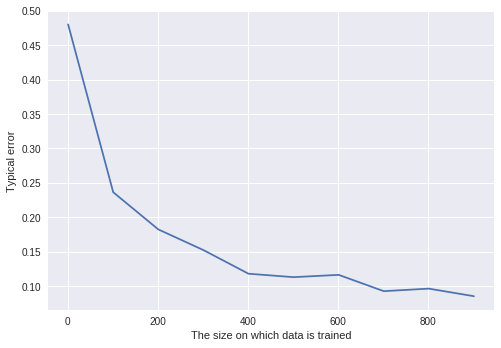

In [4]:
import math
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pylab as plt
import copy
from multiprocessing import Pool

class Node:
    def __init__(self, predict, parent_feature_val =None, data=None, values=None):
        if values is None:
            values = {}
        self.data = data
        self.values = values
        self.parent_feature_val = parent_feature_val
        self.predict = predict


def create_data(m,  k=21):
    col_names = []
    weights = []
    sum = 0
    for i in range(k):
        col_names.append("X" + str(i))
    col_names.append("Y")
    data = []
    for i in range(m):
        lst = []
        counts=0
        lst.append(random.randint(0, 1))
        for j in range(1, 15):
            choices = [lst[j-1], 1-lst[j-1]]
            prob = [0.75, 0.25]
            lst.append(np.random.choice(choices, p=prob))
        for j in range(15,21):
            lst.append(random.randint(0,1))
        if lst[0]==0:
            counts = np.bincount(np.array(lst[1:8]))
        else:
            counts = np.bincount(np.array(lst[8:15]))
        lst.append(np.argmax(counts))
        data.append(lst)

    return pd.DataFrame(data, columns=col_names)


class DecisionTreeID3:

    def __init__(self,tree=None):
        self.tree=tree

    def _entropy(self,y):

        res=0
        prob=dict(y.value_counts(normalize=True))
        for key in prob:
            res-= prob[key]*np.log2(prob[key])
        return res


    def _max_info_gain(self,data):
        info_gain={}
        for i in list(data)[:-1]:
            res=0
            entr={}
            x=dict(data[i].value_counts(normalize=True))
            for key in x:
                data_split=self._split(data,key,i)
                entr[key]=self._entropy(data_split["Y"])
                res+=x[key]*entr[key]
            info_gain[i]=self._entropy(data["Y"])-res

        return info_gain

    def _split(self, data, key, feature):
        
        return data[data[feature] == key]



    def fit_tree(self,data, tree = None):
       
        if tree == None:
            tree = Node(predict =-1)
            self.tree = tree
        if len(data["Y"].unique())==1:
            tree.data=-1
            tree.predict=int(data["Y"].unique())
            return

         
        #if len(data["Y"].unique())==0:
        #    return
        info_gain=self._max_info_gain(data)
        feature=max(info_gain,key= lambda k:info_gain[k])
#         if self.chi_square(data,feature)<threshhold:
#           return
          
        tree.data=feature
      
        for i in data[feature].unique():
            temp = Node(predict = -1)
            tree.values[i]= temp
        for j in tree.values:
            #if len(data["Y"].unique()!=1 and tree.data!=-1):
            data_split=self._split(data,j,feature)
            self.fit_tree(data_split,tree.values[j])


    def _predict_row(self,tree,row):
        current_node=tree
        feature = current_node.data
        while(feature!=-1):
            x=row[current_node.data]
            current_node=current_node.values[int(row[current_node.data])]
            feature = current_node.data
        return current_node.predict


    def predict (self, data):

        y = []

        for i in range(data.shape[0]):
            predicted_val = (self._predict_row(self.tree, data.iloc[[i]]))
            y.append(predicted_val)
        return y

    def error (self, test_data):
        wrong_prediction_count = 0
        predicted_values = self.predict(test_data)
        for i in range(len(predicted_values)):
            if predicted_values[i] != test_data["Y"][i]:
                wrong_prediction_count+= 1
        #print(predicted_values)
        #print(test_data["Y"])
        return wrong_prediction_count/len(test_data)

    #def fun(self, data):
     #   m = data[0]
      #  test_data = data[1]
       # self.fit_tree(create_data(m),tree=None)
        #iter_error=(self.error(test_data))
        #return iter_error


    def typical_error (self, m):
        test_data = create_data(300)
        error_on_m = []
        for k in range(10):
             self.fit_tree(create_data(m),tree=None)
             iter_error = 0
             iter_error=(self.error(test_data))
             error_on_m.append(iter_error)
        return sum(error_on_m)/10

    def find_irrelevant_features(self,tree,feature_list):
        temp=tree

        if temp:
            children = temp.values
            if temp.data in ["X15","X16","X17","X18","X19","X20"]:
                feature_list.append(temp.data)
            for i in children:
                self.find_irrelevant_features(children[i],feature_list)
        return len(set(feature_list))
    def chi_square(self,data,feature):
        x=dict(data[feature].value_counts(normalize=True))
        y_temp=dict(data["Y"].value_counts(normalize=True))
        t=0
        for i in x:
            for j in y_temp:
                expected_value= x[i]*y_temp[j]*len(data)
                actual_number_of_occurences= len(data[(data[feature]==i) &(data["Y"]==j )])
                t+= math.pow((expected_value-actual_number_of_occurences),2)/expected_value
        return t


feature_list=[]
dict_m={}

tup_list=[]
data=create_data(10000)
train_data,test_data=data[:8001].reset_index(drop=True),data[8001:].reset_index(drop=True)
model= DecisionTreeID3()
for i in range(1,1001,100):
  dict_m[i]=model.typical_error(i)
  print(dict_m)
plt.plot(list(dict_m.keys()),list(dict_m.values()))
plt.xlabel("The size on which data is trained")
plt.ylabel("Typical error")
